In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  plot_roc_curve, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from math import ceil
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 0

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

## EDA

## Data Distribution

In [3]:
train.shape

(250, 302)

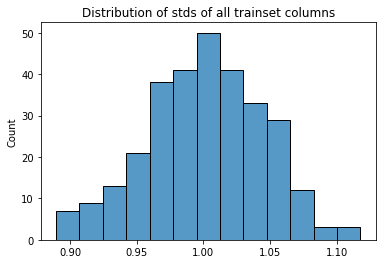

In [4]:
sns.histplot(data=train[train.columns[2:]].std())
plt.title('Distribution of stds of all trainset columns');

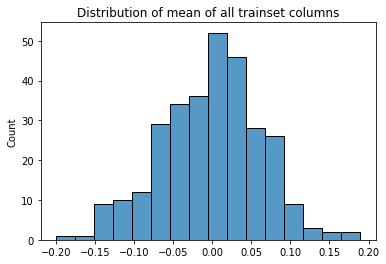

In [5]:
sns.histplot(data=train[train.columns[2:]].mean())
plt.title('Distribution of mean of all trainset columns');

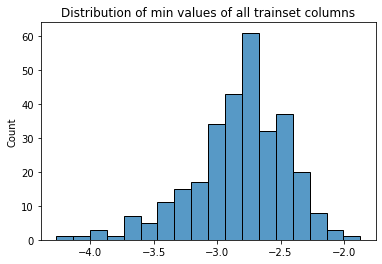

In [6]:
sns.histplot(data=train[train.columns[2:]].min())
plt.title('Distribution of min values of all trainset columns');

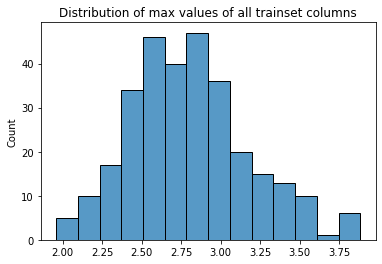

In [7]:
sns.histplot(data=train[train.columns[2:]].max())
plt.title('Distribution of max values of all trainset columns');

The standard deviation for train_set is between 0.8 and 1.125 while mean is between -0.20 and 0.2
The min and max values of trainset +/- -0.425 and  +/- 3.8 respectively.

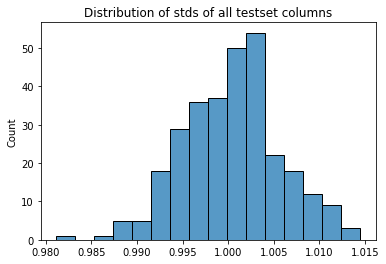

In [8]:
sns.histplot(data=test[test.columns[1:]].std())
plt.title('Distribution of stds of all testset columns');

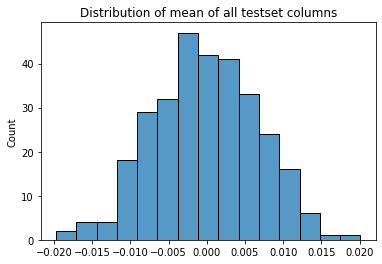

In [9]:
sns.histplot(data=test[test.columns[1:]].mean())
plt.title('Distribution of mean of all testset columns');

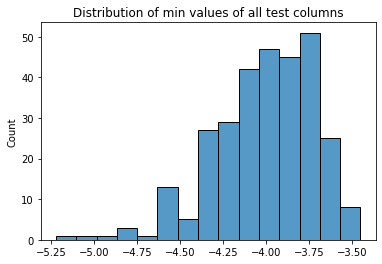

In [10]:
sns.histplot(data=test[test.columns[2:]].min())
plt.title('Distribution of min values of all test columns');

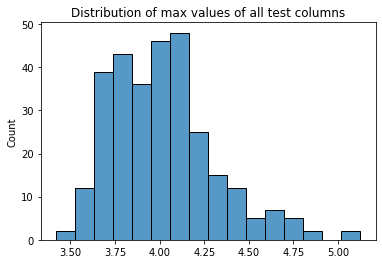

In [11]:
sns.histplot(data=test[test.columns[2:]].max())
plt.title('Distribution of max values of all test columns');

## Skewness
The data assumes a binomial distribution

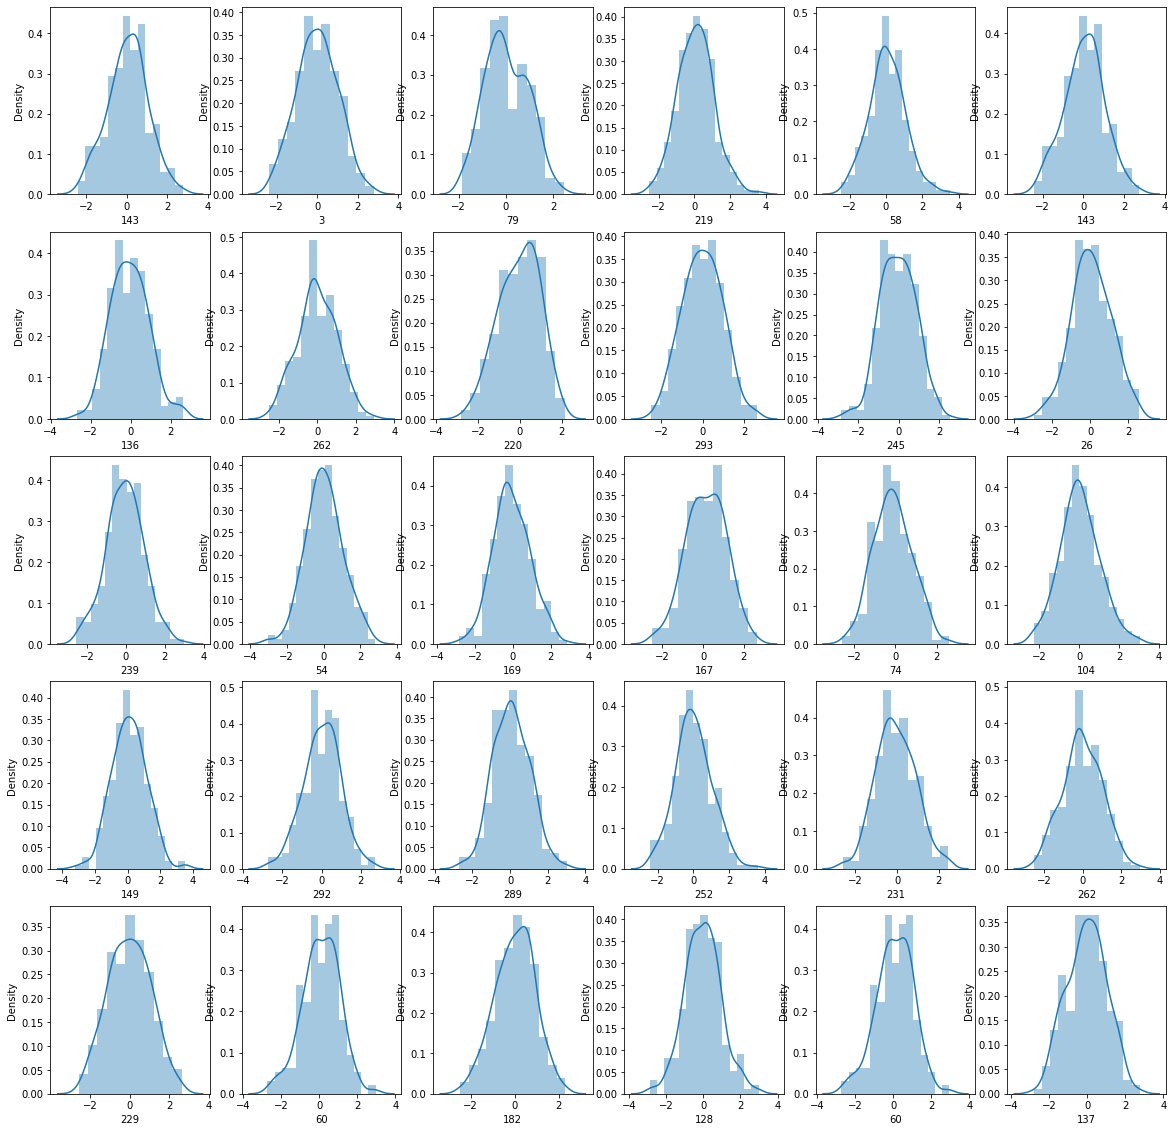

In [12]:
num = 30
r = np.random.randint(0,299,num,dtype=int)

n_cols = 6
n_rows = ceil(num/n_cols)
counter = 1

fig = plt.figure(figsize=(20,20))
for col in range(num):
    plt.subplot(n_rows, n_cols, counter)
    plt.xlabel(f"{col} feature")
    g = sns.distplot(train[str(r[col])])
    
    counter += 1

plt.show();

## Outliers
The distribution of the train dataset are close and all have similar mean

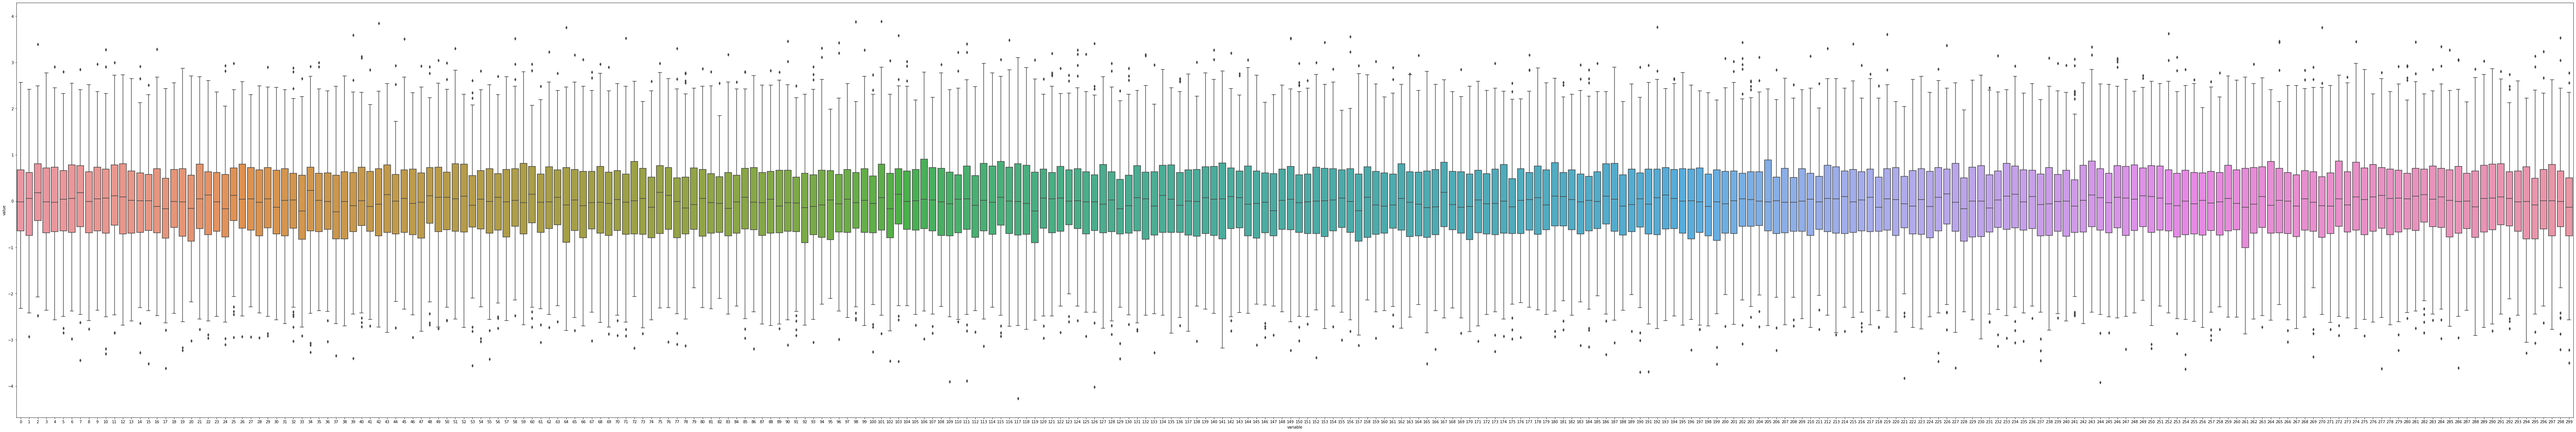

In [13]:
fig = plt.figure(figsize=(120,20))
sns.boxplot(x="variable", y="value", data=pd.melt(train.drop(columns=['id', 'target'])))

plt.show()

## Correlation
reviewing the correlations showed that features correlation with target ranges from +0.37 to -0.2

In [14]:
corr_matrix = train.corr()

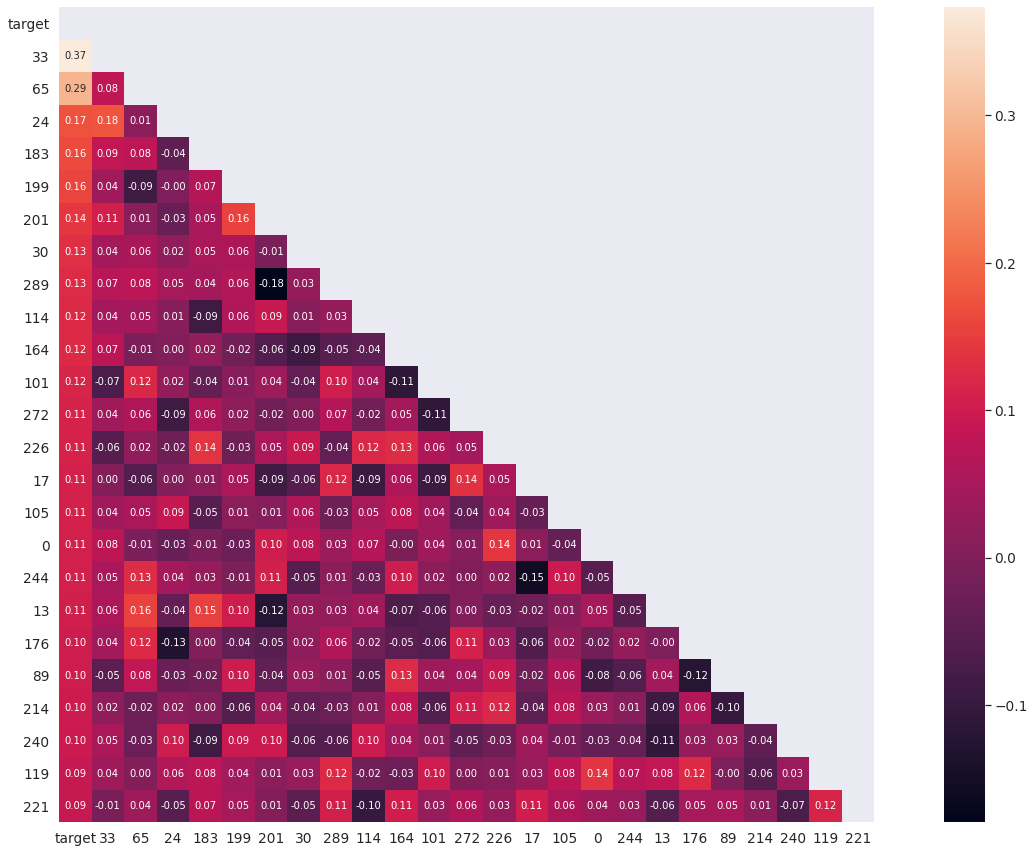

In [15]:
corr_cols = corr_matrix.nlargest(25, 'target')['target'].index
cm = np.corrcoef(train[corr_cols].values.T)
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig = plt.figure(figsize=(25,15))
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corr_cols.values, xticklabels=corr_cols.values)
plt.show()

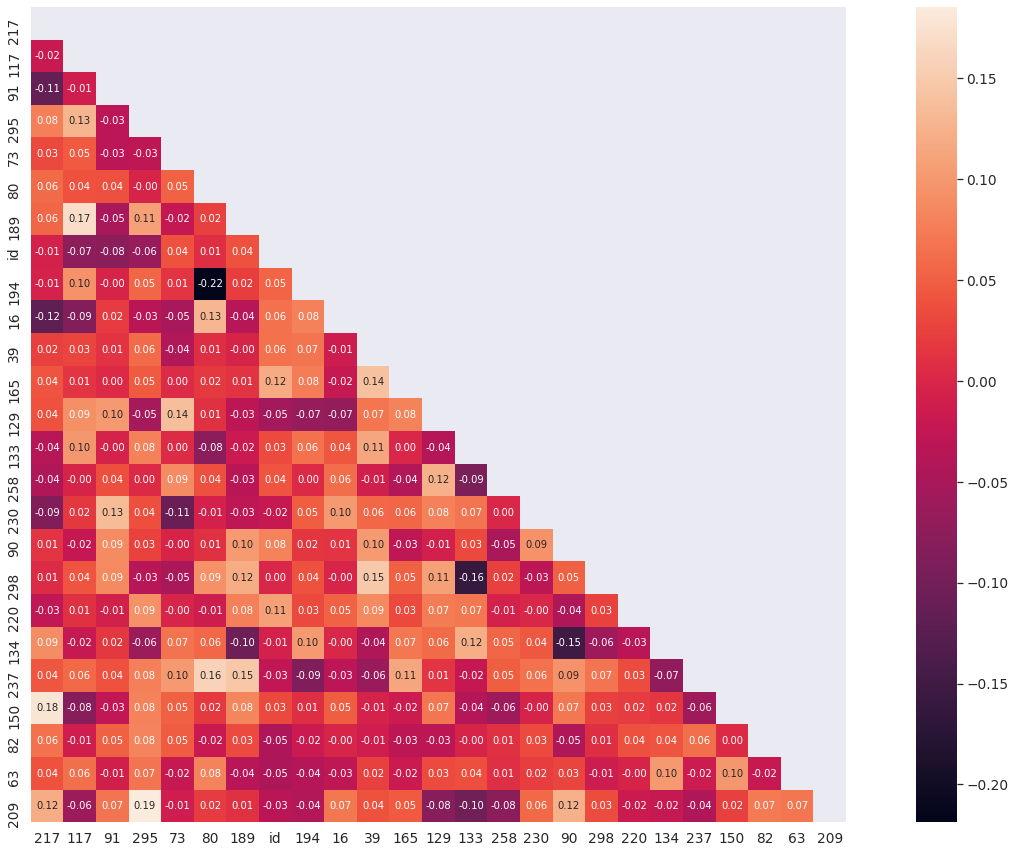

In [16]:
corr_cols = corr_matrix.nsmallest(25, 'target')['target'].index
cm = np.corrcoef(train[corr_cols].values.T)
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig = plt.figure(figsize=(25,15))
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corr_cols.values, xticklabels=corr_cols.values)
plt.show()

## Target 

The dataset target is imbalanced. 2/3 of the target belong to class 1

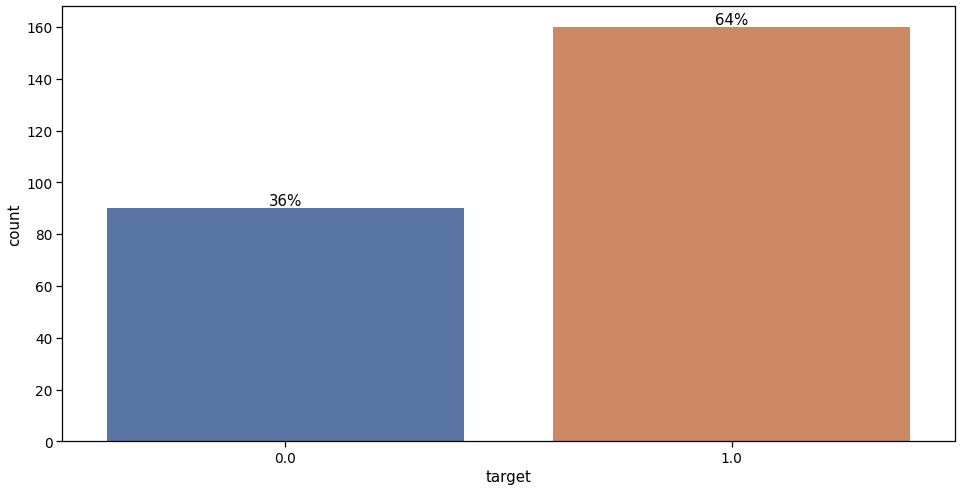

In [17]:
fig = plt.figure(figsize=(16,8))
g = sns.countplot(train['target'])
for p in g.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    g.annotate('{:.2g}%'.format(100.*y/len(train['target'])), (x.mean(), y), ha='center', va='bottom')

# Preprocessing

In [18]:
target = train['target']
test_Id = test['id']
train = train.drop(columns=['target', 'id'])
test = test.drop(columns = 'id')

In [19]:
std_scaler = StandardScaler()
std_scaler.fit(train)
train = std_scaler.transform(train)
test = std_scaler.transform(test)

# Model

The goal of the project is to achieve a score greater than 0.8 on the public board

In [29]:
models = [
          ('LogReg', LogisticRegression(C=0.1, class_weight='balanced',  max_iter=10000,
                    penalty='l1', solver='liblinear')), 
          ('RF', RandomForestClassifier(class_weight='balanced', n_estimators =  1000, max_depth = 5, max_features = 0.9, min_samples_split = 8
          )),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('GB', GradientBoostingClassifier(criterion="mse", learning_rate=0.1, max_depth=5, max_features=0.1, min_samples_split=2, n_estimators=1000)),
          ('DT', DecisionTreeClassifier(class_weight="balanced"))
        ]
dfs = []
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=90210)
    cv_results = cross_validate(model, train, target, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)

In [38]:
final.groupby(['model']).agg({'test_f1_weighted':'mean', 'test_roc_auc':'mean'}).reset_index().sort_values(by='test_roc_auc', ascending=False)

,model,test_f1_weighted,test_roc_auc
4,LogReg,0.691424,0.788636
6,SVM,0.508387,0.772571
2,GNB,0.711353,0.739030
5,RF,0.694274,0.729850
1,GB,0.637250,0.683046
3,KNN,0.606525,0.598413
0,DT,0.603387,0.585090


Based on the cross validation result and Kaggle score, Logistic Regression will be used for the result

In [32]:
logistic = LogisticRegression(C=0.1, class_weight='balanced',  max_iter=10000,
                    penalty='l1', random_state=RANDOM_STATE, solver='liblinear'
                   )
logistic.fit(train, target)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=10000, penalty='l1',
                   random_state=0, solver='liblinear')

In [33]:
logistic_pred = logistic.predict(test)

In [39]:
probs = logistic.predict_proba(test)

In [44]:
output = pd.DataFrame(
    {
        'id': test_Id,
        'target': probs[:,1]
    })
output.to_csv('output.csv', index=False)